In [1]:
import dotenv
import os
dotenv.load_dotenv()

True

# Helper Function

In [2]:
def format_task(tasks):
    task_time_pairs = []
    for task in tasks:
        task, time_str = item.rsplit(':', 1)
        time_int = int(time_str.replace('time', '').strip())
        task_time_pairs.append((task, time))
    return task_time_pairs

# GraphState

In [3]:
from typing import TypedDict

In [4]:
class GraphState(TypedDict):
    goal: str
    todo: list[str]
    current_job: str
    total_time: int
    time_spent: int
    status: str

# Node & Edge

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import CommaSeparatedListOutputParser

In [6]:
def create_todo_list(goal):
    output_parser = CommaSeparatedListOutputParser()
    prompt = ChatPromptTemplate.from_messages(
        [
            ('system', 'You are my secretary. You should build a todo list for me'),
            ('human', "Please write a todo list for performing the goal. The format for the todo list should be 'task: hour' where task is the task to achieve the goal, and hour means the time requires for acheving the task. You should round up the time so that the time can be an integer. \n\n#Goal: {goal}\n\n#format: {format_instructions}"),
        ]
    )
    prompt = prompt.partial(format_instructions=output_parser.get_format_instructions())
    llm = ChatOpenAI(model_name='gpt-4o-mini')

    chain = prompt | llm | CommaSeparatedListOutputParser()
    
    output = chain.invoke({'goal': goal})
    return output
    

In [7]:
todo = create_todo_list('Study LangGraph')

In [8]:
print(todo)

['Research LangGraph basics: 2', 'Set up development environment: 1', 'Complete introductory tutorials: 3', 'Build a simple project using LangGraph: 4', 'Review project and document learnings: 2', 'Join LangGraph community forums: 1', 'Explore advanced features and functionalities: 3', 'Practice by creating additional projects: 5']


# Define specific function for each nodes

In [9]:
def list_todo(state: GraphState) -> GraphState:
    goal = state['goal'] # return the value of the key, goal
    todo = create_todo_list(goal)
    todo = format_task(todo)
    
    return GraphState(todo=todo)

In [10]:
def start_job(state: GraphState) -> GraphState:
    todo = state['todo']
    if len(todo):
        current_job, total_time = todo.pop(0)
        status = 'work in progress'
        time_spent = 0
    return GraphState(
        current_job=current_job,
        total_time=total_time,
        status=status,
        time_spent=time_spent,
    )

In [11]:
def process_job(state: GraphState) -> GraphState:
    time_spent = state['time_spent']
    time_spent += 1
    
    return GraphState(time_spent=time_spent)

In [18]:
def check_progress(state: GraphState) -> GraphState:
    if state['time_spent'] >= state['total_time']:
        status = 'next task'
        if len(state['todo']) == 0:
            status = 'done'
    else:
        status = 'work in progress'
    return GraphState(status=status)

In [13]:
def next_step(state: GraphState) -> GraphState:
    return state['status']

# Define Graph

In [17]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

In [20]:
workflow = StateGraph(GraphState)

workflow.add_node('list_todo', list_todo)

workflow.add_node('start_job', start_job)

workflow.add_node('process_job', process_job)

workflow.add_node('check_progress', check_progress)

workflow.add_edge('list_todo', 'start_job')
workflow.add_edge('start_job', 'process_job')
workflow.add_edge('process_job', 'check_progress')

workflow.add_conditional_edges(
    'check_progress',
    next_step,
    {
        'work in progress': 'process_job',
        'next task': 'start_job',
        'done': END,
    },
)

In [21]:
workflow.set_entry_point('list_todo')
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# Visualize Graph

In [22]:
from IPython.display import Image, display

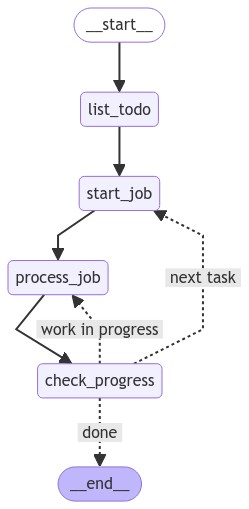

In [25]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# Execute

In [26]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

In [ ]:
config = RunnableConfig(recursion_limit=100, configurable={'thread_id': 'TODO'})

inputs = GraphState(goal='finish the lagngraph practice task given by Professor Suh')

try:
    for output in app.stream(inputs, config=config):
        for key, value in output.items():
            pprint.pprint(f'[NODE] {key}')
            
            for k, v in value.items():
                pprint.pprint(f'<{k}> {v}')
            oorint.pprint('===' * 10)
except GraphRecursionError as e:
    pprint.pprint(f'Recu
                        